# 🏋️ Fun with Text and Image Embeddings 🍎

Welcome to our **Health & Fitness** embeddings notebook! In this tutorial, we'll show you how to:

1. **Initialize** an `AIProjectClient` to access your Azure AI Foundry project.
2. **Embed text** using `azure-ai-inference` with our fun health-themed phrases.
3. **Embed images** using `azure-ai-inference` (we're using Cohere's image embeddings model).
4. **Generate a health-themed image** (example code) and display it.
5. **Use a prompt template** for extra context.

Let's get started and have some fun with our healthy ideas! 🍏

> **Disclaimer**: This notebook is for educational purposes only. Always consult a professional for medical advice.

<img src="./seq-diagrams/2-embeddings.png" width="30%"/>

## 1. Setup & Environment

#### Prerequisites:
- Deploy a text embeddings model (**text-embedding-3-small**) in Azure AI Foundry
- Deploy a image embeddings model (**Cohere-embed-v3-english**) in Azure AI Foundry
#
We'll import our libraries and load the environment variables for:
- `PROJECT_CONNECTION_STRING`: Your project connection string.
- `TEXT_EMBEDDING_MODEL`: The text embeddings model deployment name.
- `IMAGE_EMBEDDING_MODEL`: The image embeddings model deployment name.

We'll import libraries, load environment variables, and create an `AIProjectClient`.

> #### Complete [1-basic-chat-completion.ipynb](./1-basic-chat-completion.ipynb) notebook before starting this one
Let's begin! 🚀

In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.inference.models import ImageEmbeddingInput

# Load environment variables
notebook_path = Path().absolute()
parent_dir = notebook_path.parent
load_dotenv(parent_dir / '.env')

# Retrieve from environment or fallback
PROJECT_CONNECTION_STRING = os.environ.get("PROJECT_CONNECTION_STRING", "<your-connection-string>")
TEXT_EMBEDDING_MODEL = os.environ.get("TEXT_EMBEDDING_MODEL", "text-embedding-3-small")
IMAGE_EMBEDDING_MODEL = os.environ.get("IMAGE_EMBEDDING_MODEL", "Cohere-embed-v3-english")

# Initialize project client
try:
    project_client = AIProjectClient.from_connection_string(
        credential=DefaultAzureCredential(),
        conn_str=PROJECT_CONNECTION_STRING,
    )
    print("🎉 Successfully created AIProjectClient")
except Exception as e:
    print("❌ Error creating AIProjectClient:", e)

🎉 Successfully created AIProjectClient


## 2. Text Embeddings

We'll call `get_embeddings_client()` from our `AIProjectClient` to retrieve the embeddings client. Then we'll embed some fun health-themed phrases:

- "🍎 An apple a day keeps the doctor away"
- "🏋️ 15-minute HIIT workout routine"
- "🧘 Mindful breathing exercises"

The output will be numeric vectors representing each phrase in semantic space. Let’s see those embeddings!

In [2]:
text_phrases = [
    "An apple a day keeps the doctor away 🍎",
    "Quick 15-minute HIIT workout routine 🏋️",
    "Mindful breathing exercises 🧘"
]

try:
    with project_client.inference.get_embeddings_client() as embed_client:
        response = embed_client.embed(
            model=TEXT_EMBEDDING_MODEL,
            input=text_phrases
        )

        for item in response.data:
            vec = item.embedding
            sample_str = f"[{vec[0]:.4f}, {vec[1]:.4f}, ..., {vec[-2]:.4f}, {vec[-1]:.4f}]"
            print(f"Sentence {item.index}: '{text_phrases[item.index]}':\n" \
                  f"  Embedding length={len(vec)}\n" \
                  f"  Sample: {sample_str}\n")
except Exception as e:
    print("❌ Error embedding text:", e)

Sentence 0: 'An apple a day keeps the doctor away 🍎':
  Embedding length=1536
  Sample: [-0.0213, -0.0037, ..., -0.0084, 0.0337]

Sentence 1: 'Quick 15-minute HIIT workout routine 🏋️':
  Embedding length=1536
  Sample: [-0.0583, 0.0209, ..., 0.0095, -0.0158]

Sentence 2: 'Mindful breathing exercises 🧘':
  Embedding length=1536
  Sample: [-0.0097, 0.0470, ..., 0.0402, 0.0018]



## 3. Prompt Template Example 📝

Even though our focus is on embeddings, here's how you might prepend some context to a user message. Imagine you want to embed user text but first add a system prompt such as “You are HealthFitGPT, a fitness guidance model…” This little extra helps set the stage for more context-aware embeddings.


In [3]:
# A basic prompt template (system-style) we'll prepend to user text.
TEMPLATE_SYSTEM = (
    "You are HealthFitGPT, a fitness guidance model.\n"
    "Please focus on healthy advice and disclaim you're not a doctor.\n\n"
    "User message:"  # We'll append the user message after this.
)

def embed_with_template(user_text):
    """Embed user text with a system template in front."""
    content = TEMPLATE_SYSTEM + " " + user_text
    with project_client.inference.get_embeddings_client() as embed_client:
        rsp = embed_client.embed(
            model=TEXT_EMBEDDING_MODEL,
            input=[content]
        )
    return rsp.data[0].embedding

sample_user_text = "Can you suggest a quick home workout for busy moms?"
embedding_result = embed_with_template(sample_user_text)
print("Embedding length:", len(embedding_result))
print("First few dims:", embedding_result[:8])

Embedding length: 1536
First few dims: [0.00024832287, 0.038954947, -0.01699466, 0.025093678, -0.040707525, -0.0024197476, -0.03595433, 0.07275839]


## 4. Image Embeddings

Image embeddings typically require managed compute resources. While Azure AI Foundry offers specialized models (like **MedImageInsight**) for medical images, in this example we'll use Cohere's serverless image embedding model.

Here we are using the **`hand-xray.png`** image to generate embeddings. This image (of a hand X-ray) is our fun nod to health-themed imagery!

In [4]:
try:
    with project_client.inference.get_image_embeddings_client() as img_embed_client:
        # Construct input for the image embeddings call
        img_input = ImageEmbeddingInput.load(image_file="hand-xray.png", image_format="png")
        resp = img_embed_client.embed(
            model=IMAGE_EMBEDDING_MODEL,
            input=[img_input]
        )

        for item in resp.data:
            vec = item.embedding
            snippet = f"[{vec[0]:.4f}, {vec[1]:.4f}, ..., {vec[-2]:.4f}, {vec[-1]:.4f}]"
            print(f"Image index={item.index}, length={len(vec)}, sample={snippet}")
except Exception as e:
    print("❌ Error embedding image:", e)

Image index=0, length=1024, sample=[0.0314, -0.0194, ..., -0.0091, 0.0015]


## 5. Generate a Health-Related Image 🏃 (Optional)

> **Note**: Image generation is currently not supported in the `azure-ai-inference` SDK. The example below uses the `openai` SDK with Azure OpenAI's DALL-E 3 model. This section will be updated once image generation is supported in the `azure-ai-inference` SDK.

Let's generate a health-themed image using Azure OpenAI's DALL-E-3 model. You'll need:
1. A DALL-E-3 model deployment in your Azure OpenAI resource
2. The `openai` Python package installed (`pip install openai`)
3. Your Azure OpenAI endpoint and API key set in environment variables

We'll pass a simple prompt describing a healthy scenario and display the generated image inline.


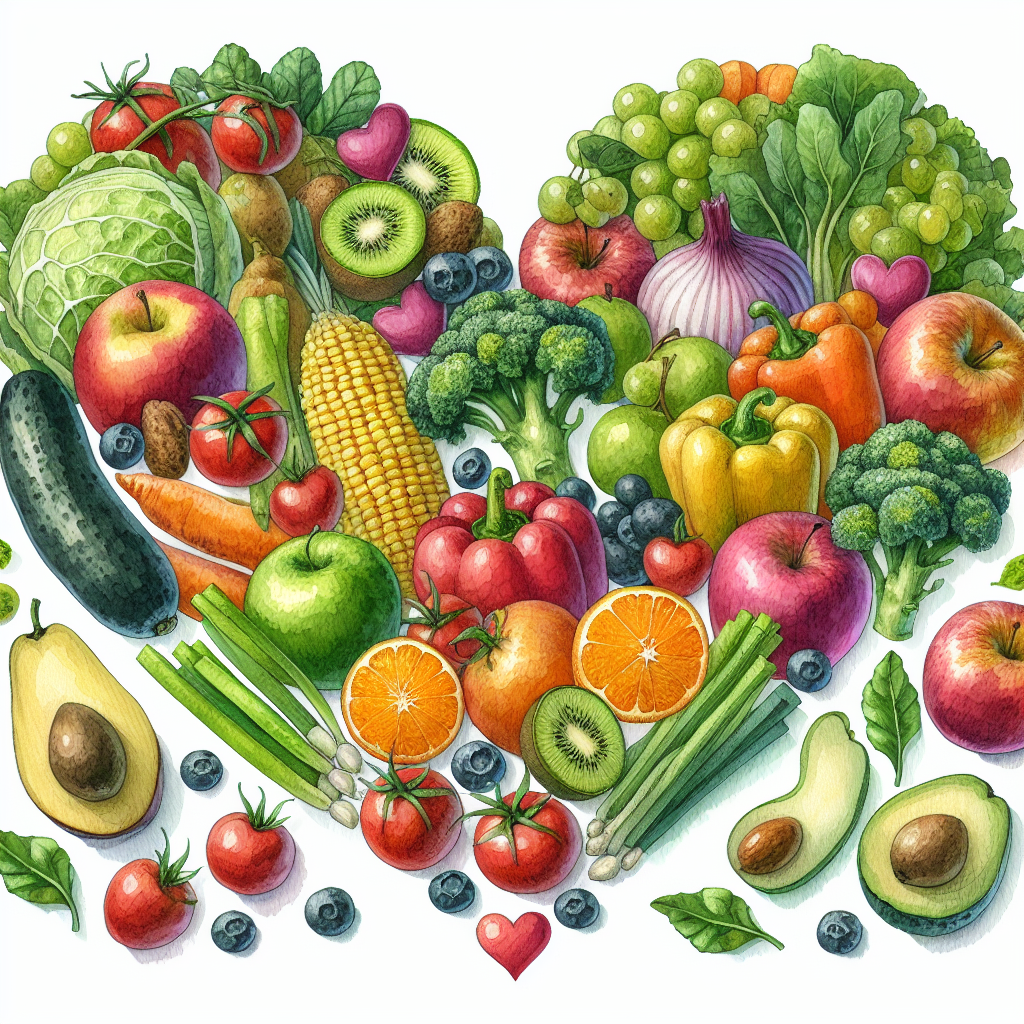

In [12]:
import os
from openai import AzureOpenAI
import requests
from PIL import Image
from IPython.display import display

def generate_health_image(prompt="A simple cartoon of a happy person jogging outdoors"):
    try:
        # Initialize Azure OpenAI client
        client = AzureOpenAI(
            api_version="2024-02-01",
            api_key=os.getenv("AZURE_OPENAI_API_KEY", "E19drKIw0Xs4qiciVqNizUlx3DPPW4hb1k0ejMzi3UINvQhEwhgKJQQJ99BAACYeBjFXJ3w3AAAAACOGGzkU"),
            azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT", "https://ai-adminai3148890574496362.openai.azure.com")
        )
        
        # Generate image
        result = client.images.generate(
            model="dall-e-3", # your DALL-E 3 deployment name
            prompt=prompt,
            n=1
        )
        
        # Download and display image
        image_url = result.data[0].url
        image_data = requests.get(image_url).content
        
        # Save temporarily and display
        with open("temp_image.png", "wb") as f:
            f.write(image_data)
        img = Image.open("temp_image.png")
        display(img)
        
        # Clean up
        os.remove("temp_image.png")
        
    except Exception as e:
        print("❌ Error generating image:", e)

# Let's try generating a health image
generate_health_image("A watercolor painting of fresh fruits and vegetables arranged in a heart shape")

## 6. Wrap-Up & Next Steps
🎉 We've shown how to:
- Set up the `AIProjectClient`.
- Get **text embeddings** using *text-embedding-3-small*.
- Get **image embeddings** using *Cohere-embed-v3-english* on a health-themed (hand X-ray) image.
- **Generate** a health-themed image (example code).
- Use a **prompt template** to add system context to your embeddings.

**Where to go next?**
- Explore `azure-ai-evaluation` for evaluating your embeddings.
- Use `azure-core-tracing-opentelemetry` for end-to-end telemetry.
- Build out a retrieval pipeline to compare similarity of embeddings.

Have fun experimenting, and remember: when it comes to your health, always consult a professional!